In [1]:
import pandas as pd
import os
import sys
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params, reg_plot
from matplotlib import pyplot as plt
import seaborn as sns

TODO:
 - rerun loop with phred_score = 10
 - redo heatplots with freq > 0.05
 - transitions and transversions analysis
 - averages between sequencing methods similiar but changing through passages for syn mutations under 1% and only for transitions
 - low frequency errors distribtion across sequencing methods????? ask Noam

In [2]:
types = pd.read_csv('../data/mutation_types_short.csv')

In [3]:
types.loc[types.Pos==1649]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4488,1649,T,A,False,cp,1335,1727,NaN
4489,1649,T,C,False,cp,1335,1727,NaN
4490,1649,T,G,False,cp,1335,1727,I105M


In [4]:
types.loc[types.Pos==1691]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4653,1691,T,A,False,cp,1335,1727,NaN
4654,1691,T,C,False,cp,1335,1727,NaN
4655,1691,T,G,False,cp,1335,1727,I119M
4656,1691,T,A,False,lys,1678,1905,F5Y
4657,1691,T,C,False,lys,1678,1905,F5S
4658,1691,T,G,False,lys,1678,1905,F5C


In [5]:
types.loc[types.Pos==1685]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4617,1685,C,A,False,cp,1335,1727,N117K
4618,1685,C,T,False,cp,1335,1727,NaN
4619,1685,C,G,False,cp,1335,1727,N117K
4620,1685,C,A,False,lys,1678,1905,T3N
4621,1685,C,T,False,lys,1678,1905,T3I
4622,1685,C,G,False,lys,1678,1905,T3S


In [6]:
types.loc[types.Pos==1697]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4689,1697,A,C,False,cp,1335,1727,NaN
4690,1697,A,T,False,cp,1335,1727,NaN
4691,1697,A,G,False,cp,1335,1727,NaN
4692,1697,A,C,False,lys,1678,1905,Q7P
4693,1697,A,T,False,lys,1678,1905,Q7L
4694,1697,A,G,False,lys,1678,1905,Q7R


In [7]:
ifreqs = pd.read_csv("../data/illumina_newpipe_freqs.csv")
lfreqs = pd.read_csv('../data/new_loop_freqs.csv')

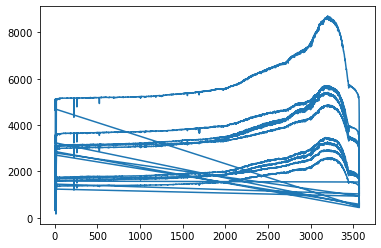

In [8]:

plt.plot(lfreqs.ref_pos, lfreqs.coverage)

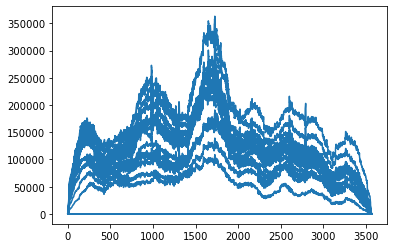

In [9]:
plt.plot(ifreqs.ref_pos, ifreqs.coverage)

In [10]:
def get_mutation_data(freqs):
    mutation_data = freqs[(freqs.frequency>0.001) & (freqs.frequency<0.5) & (freqs.coverage>50) & 
                          (freqs.ref_pos>23) & (freqs.ref_pos<=3541)].copy()
    return mutation_data

In [11]:
imutation = get_mutation_data(ifreqs)
lmutation = get_mutation_data(lfreqs)

In [12]:
imutation['source'] = 'illumina'
lmutation['source'] = 'loop'

In [13]:
mutations = pd.concat([lmutation,imutation])

In [14]:
set_plots_size_params(30)

In [15]:
def mutation_time_series(df, ax, colors_dict, going=None, just_one=None):
    if just_one:
        if df.source.iloc[0] != just_one:
            return
    x = df.passage
    y = df.frequency
    if going=='up':
        if y.iloc[0] >= y.iloc[-1]*0.7:
            return
    if going=='down':
        if y.iloc[0] <= y.iloc[-1]*0.7:
            return
    label = f"{df.ref_pos.iloc[0]}{df.read_base.iloc[0]}"
    if label in colors_dict.keys():
        color = colors_dict[label]
        alpha = 1
    else:
        color = 'black'
        label = None
        alpha = 0.1
    if df.source.iloc[0] == "loop":
        linestyle='dashed'
    else:
        linestyle='solid'
    ax.plot(x, y, color=color, label=label, alpha=alpha, linestyle=linestyle)
    # ax.text(x.iloc[-1], y.iloc[-1], label)  # <- text next to plot!
    return ax


In [16]:
top_mutations = mutations.groupby(['ref_pos','read_base']).frequency.max().sort_values(ascending=False).head(12).index
top_mutations = [f'{ref_pos}{read_base}' for (ref_pos, read_base) in top_mutations]
color_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45',
              '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
              '#000075', '#000000']
color_dict = {top_mutations[i]: color_list[i] for i in range(len(top_mutations))}


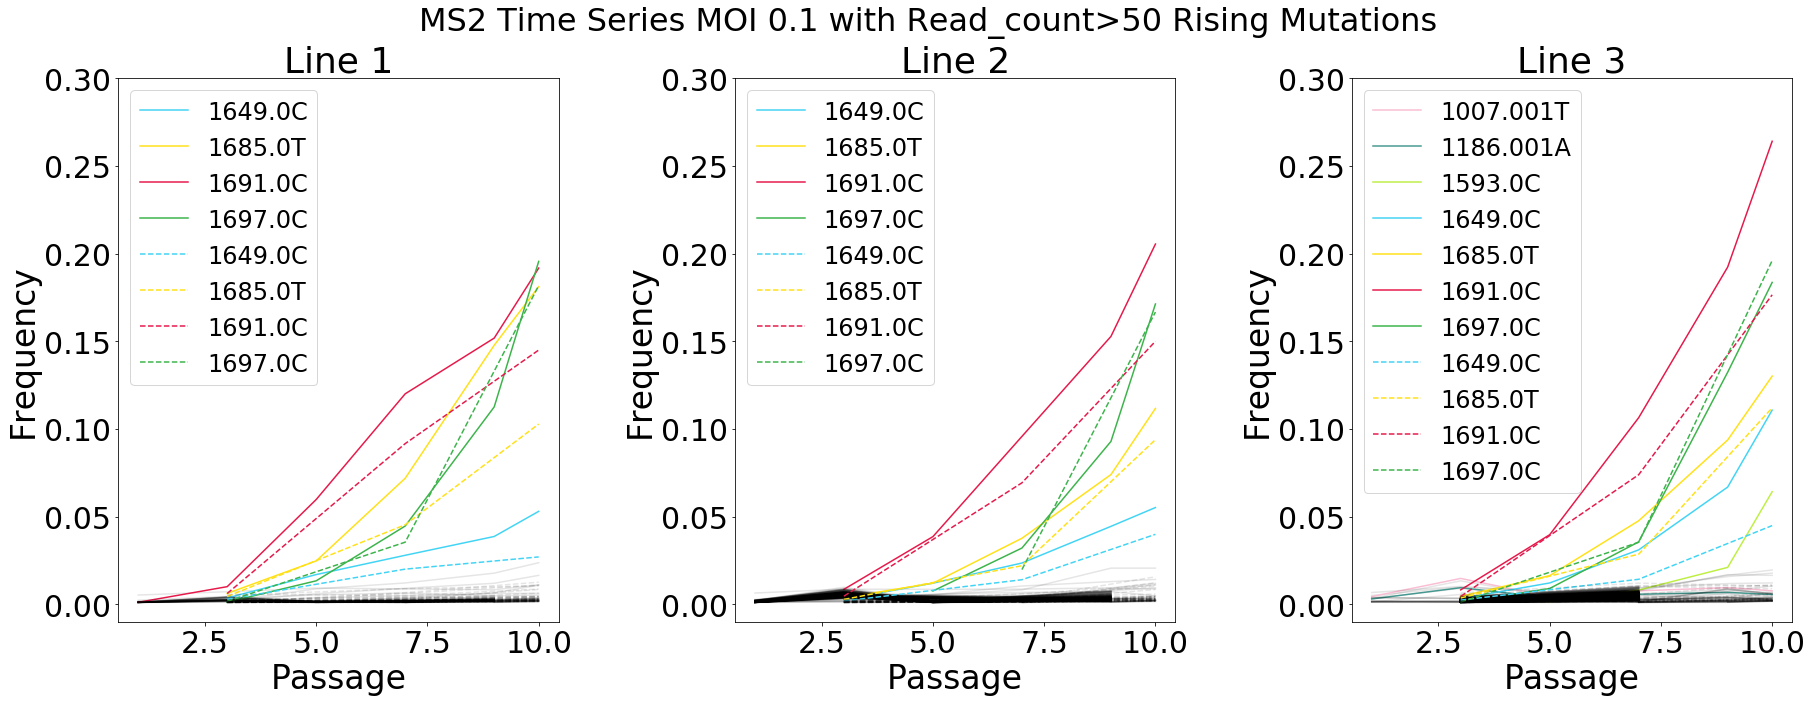

In [17]:
fig, axes = plt.subplots(figsize=(30, 10), ncols=3, nrows=1)
plt.suptitle("MS2 Time Series MOI 0.1 with Read_count>50 Rising Mutations", fontsize=32)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
for i in range(3):
    km_muts = mutations[mutations.km==i+1]
    km_muts.groupby(['source','ref_pos', 'read_base']).apply(
        lambda df: mutation_time_series(df, axes[i], color_dict, going='up'))
    axes[i].set_ylim([-0.01,0.3])
    axes[i].legend()
    axes[i].set_title(f"Line {i+1}")
    axes[i].set_xlabel('Passage')
    axes[i].set_ylabel('Frequency')

In [18]:
fig.savefig('rising_muts.png')

In [19]:
def mutations_box_plots(data, title, log_scale, save_fig_path=None):
    fig, axes = plt.subplots(figsize=(60, 15), ncols=3, nrows=1)
    plt.suptitle(title, fontsize=32)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    for i in range(3):
        km_muts = data[data.km==i+1]
        daplot = sns.boxplot(data=km_muts, x='passage', y='frequency', hue='source', ax=axes[i], showmeans=True,
                             meanprops={"markersize":10, "marker":"o" ,"markerfacecolor":"red", "markeredgecolor":"red"})
        daplot.set_title(f"Mutations in Line {i+1}")
        if log_scale:
            daplot.set_yscale('log')
        if save_fig_path:
            fig.savefig(save_fig_path) 
    return daplot

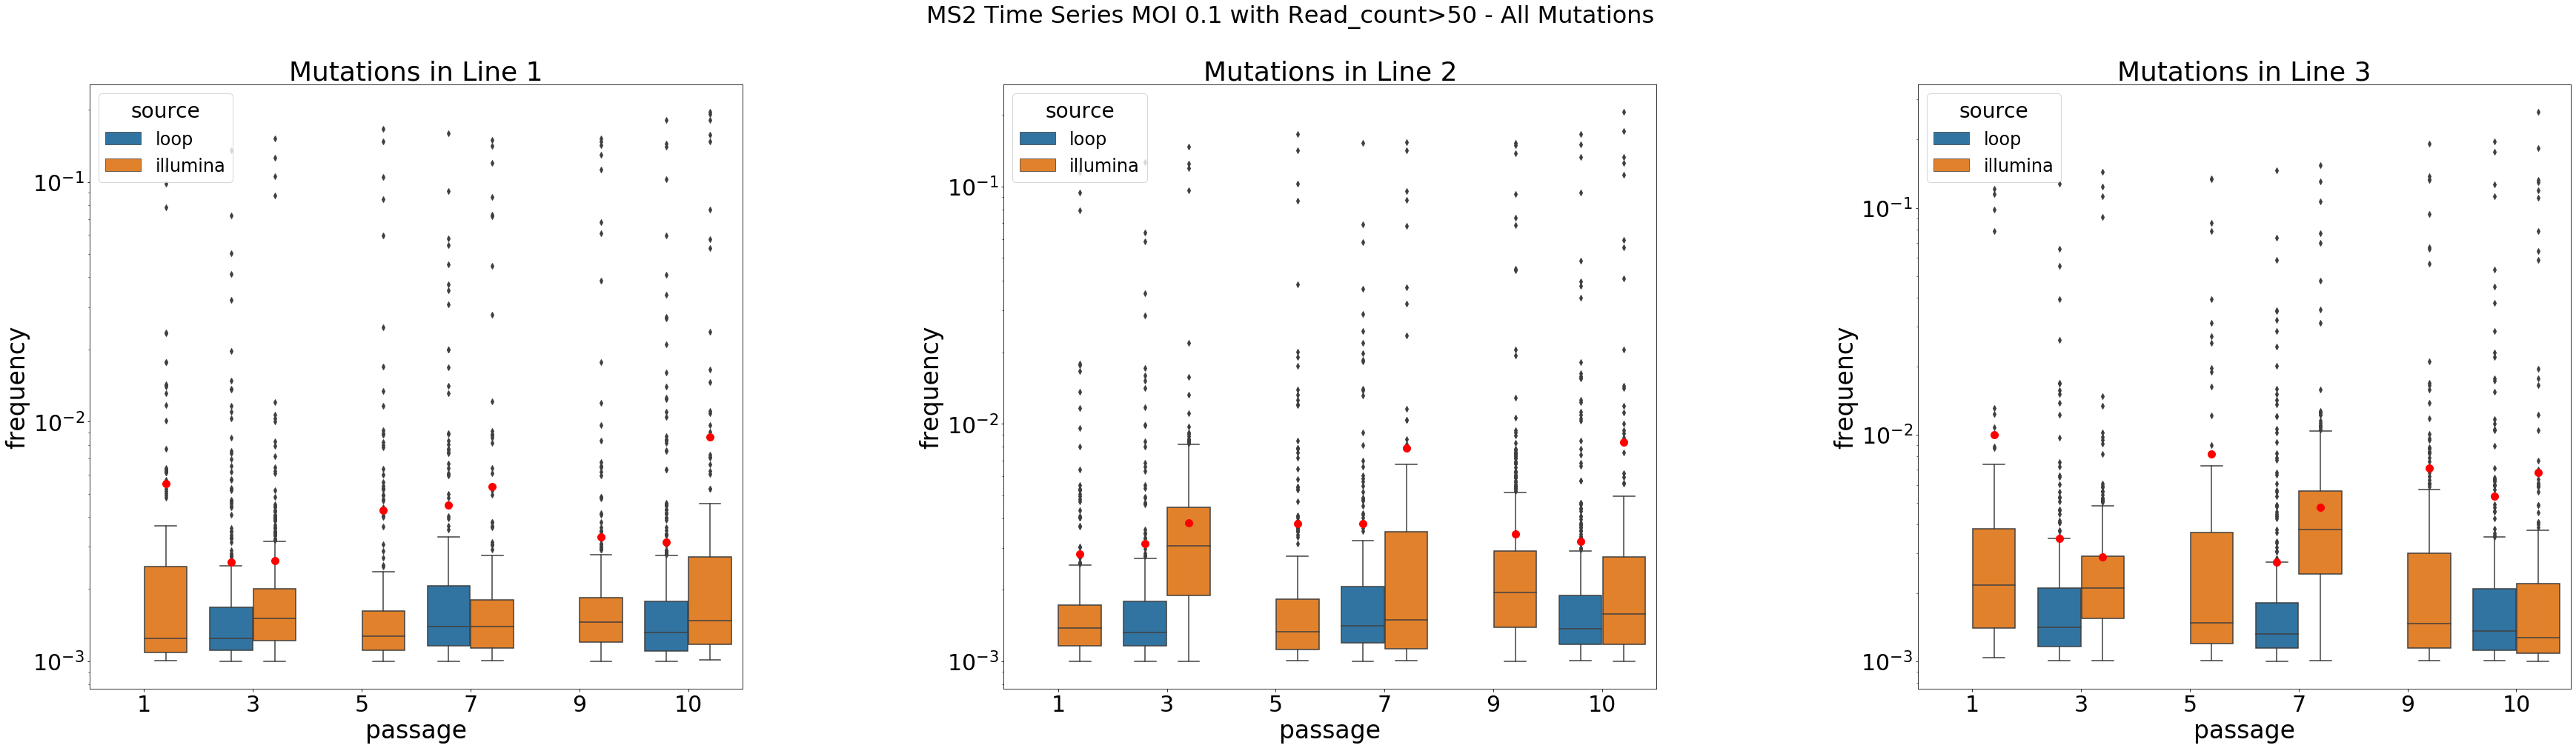

In [20]:
mutations_box_plots(mutations, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 - All Mutations", 
                    log_scale=True)

## Rather concerning but if we filter out oxidation mutations:

In [21]:
def is_oxidation(row):
    if (row.ref_base=="C" and row.read_base=='A') or (row.ref_base=='G' and row.read_base=='T'):
        return True
    return False

In [22]:
mutations['oxidation'] = mutations.apply(is_oxidation, axis=1)

In [23]:
not_oxidation = mutations[~mutations.oxidation]

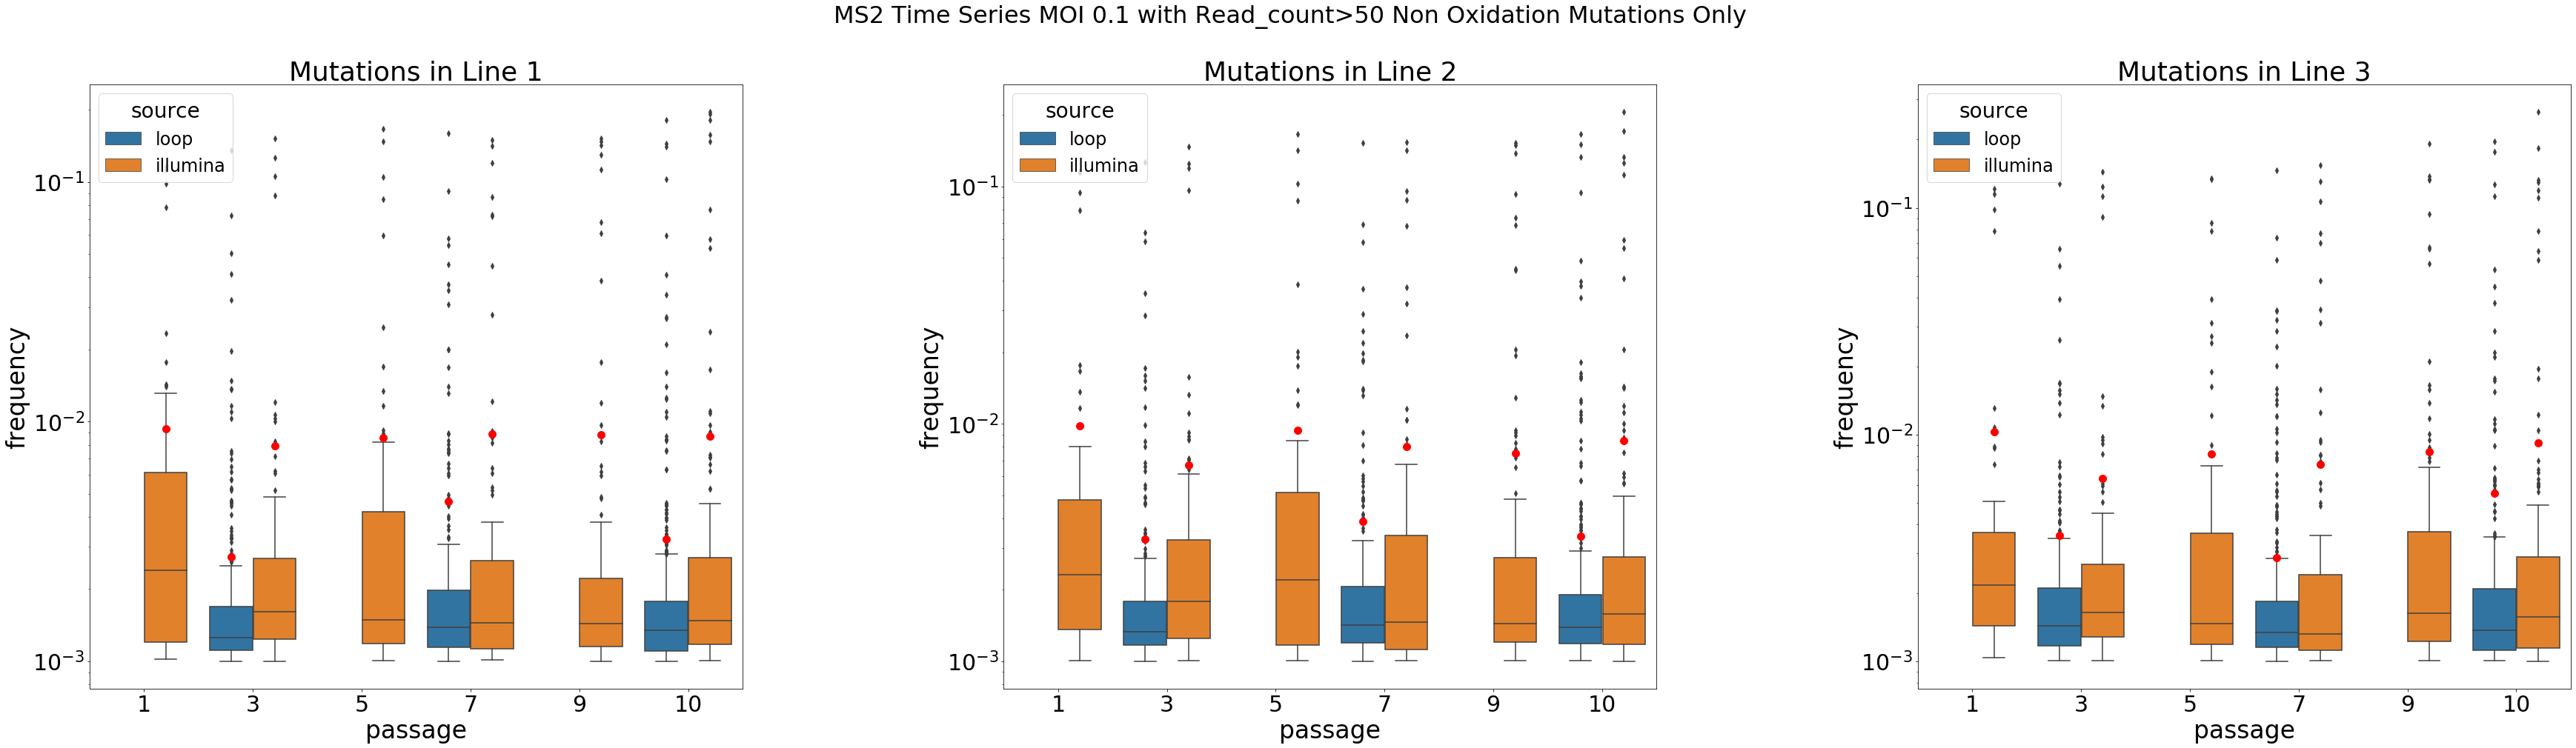

In [24]:
mutations_box_plots(not_oxidation, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Non Oxidation Mutations Only", 
                    log_scale=True)

In [25]:
joint_mutations = mutations[mutations.duplicated(['km','passage','ref_pos','read_base'], keep=False)].copy()
mutations_in_both = joint_mutations[joint_mutations.source=='illumina'].merge(
    joint_mutations[joint_mutations.source=='loop'], on=['km','passage','ref_pos','read_base','ref_base'], 
    suffixes=('_i','_l'))[['ref_pos', 'read_base', 'ref_base', 'km','passage',
                           'base_count_i', 'coverage_i', 'frequency_i', 'base_rank_i', 
                           'base_count_l', 'coverage_l', 'frequency_l', 'base_rank_l']]
mutations_in_both['freq_ratio'] = mutations_in_both['frequency_i'] / mutations_in_both['frequency_l']

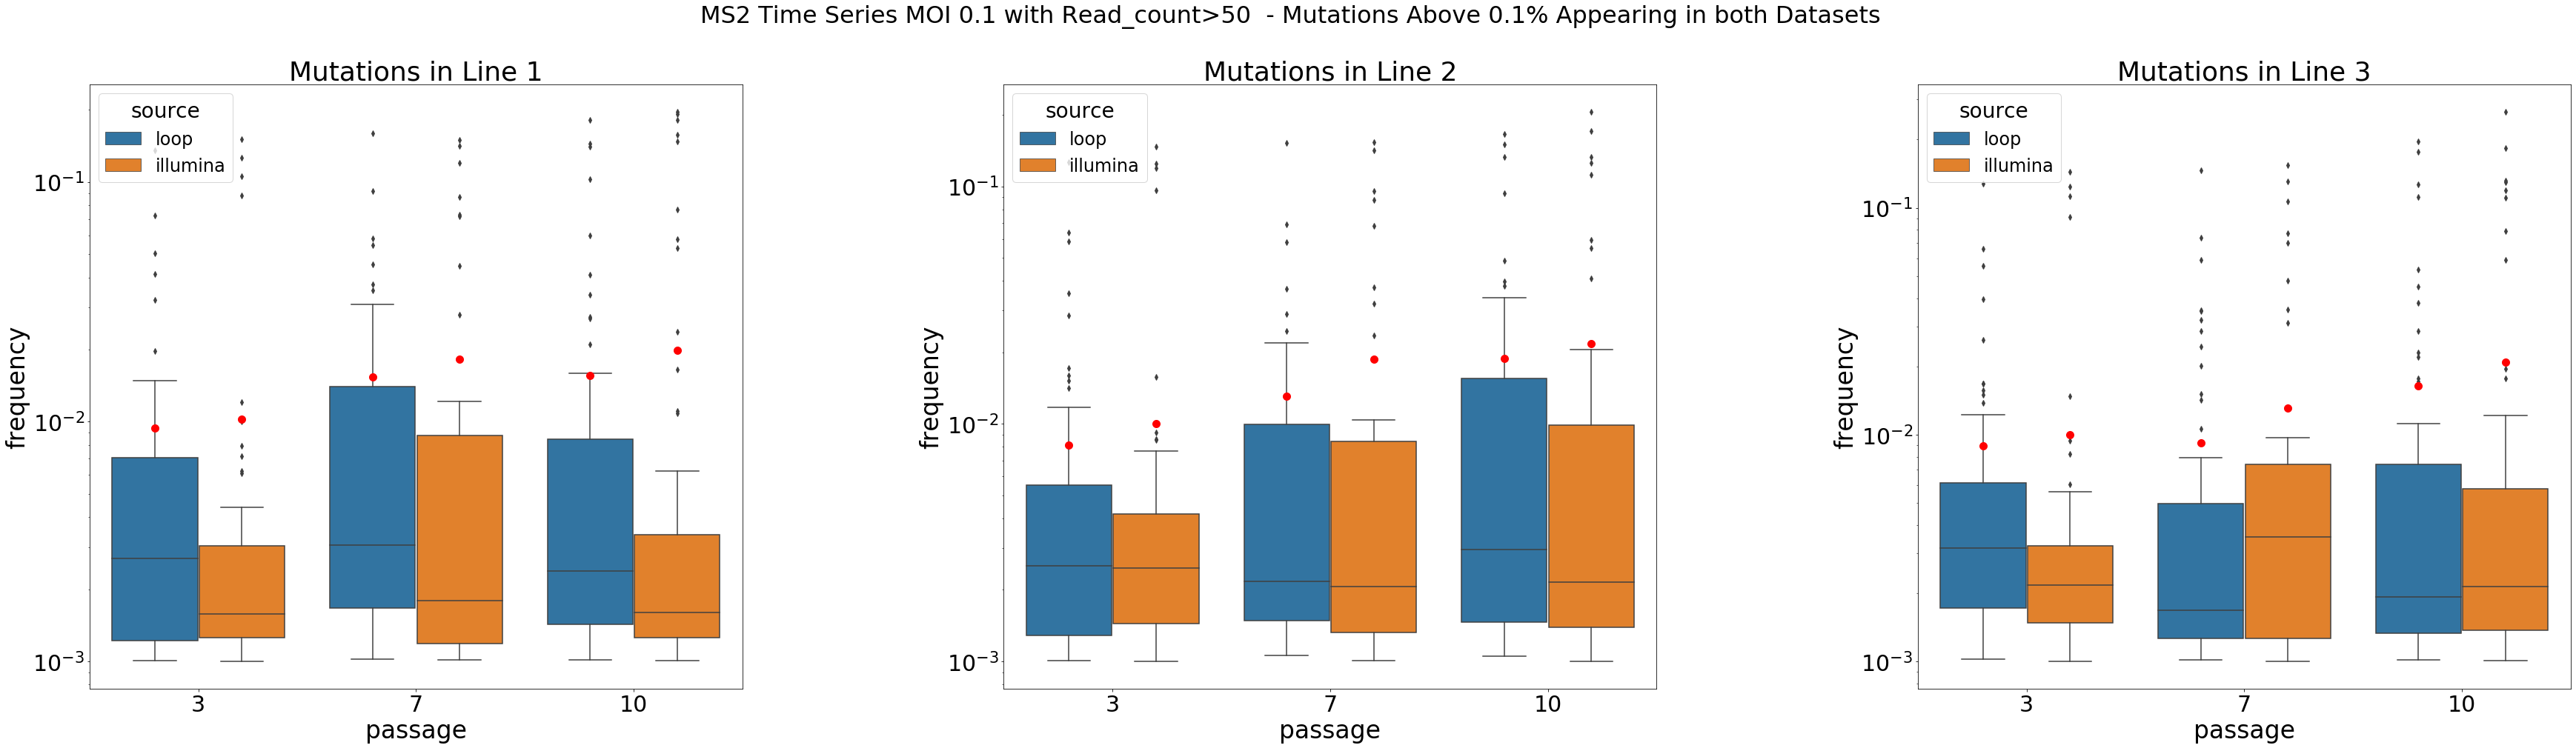

In [26]:
mutations_box_plots(joint_mutations, 
                    "MS2 Time Series MOI 0.1 with Read_count>50  - Mutations Above 0.1% Appearing in both Datasets", 
                    log_scale=True, save_fig_path="joint_boxplots_above_001.png")

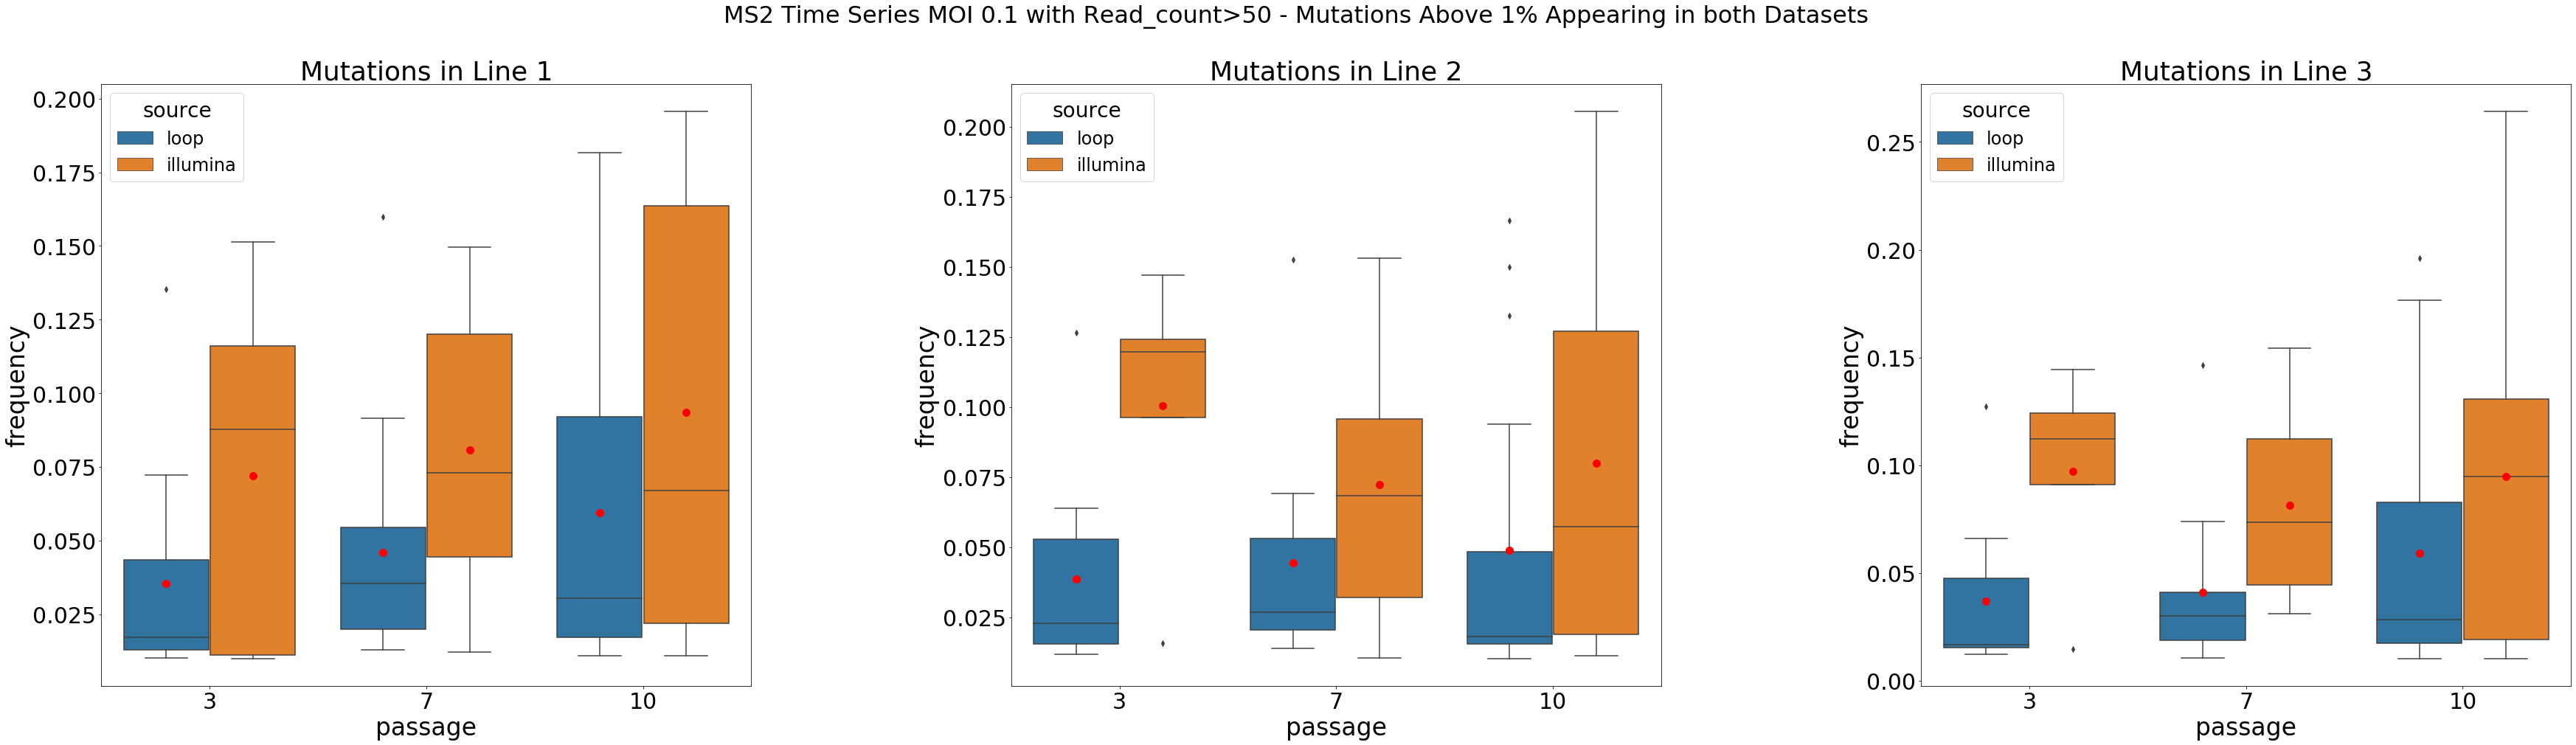

In [27]:
mutations_box_plots(joint_mutations[joint_mutations.frequency>0.01], 
                    "MS2 Time Series MOI 0.1 with Read_count>50 - Mutations Above 1% Appearing in both Datasets", 
                    log_scale=False, save_fig_path="joint_boxplots_above_01.png")

In [28]:
loop_test = joint_mutations[joint_mutations.source=='loop']
ill_test = joint_mutations[joint_mutations.source=='illumina']

In [60]:
def reg_plot(x, y, size=None, save_to=None, marker=None, alpha=None, color=None, label=None):
    if size is None:
        size = 10
    max_val = max(max(x), max(y))
    min_val = min(min(x), min(y))
    set_plots_size_params(size*2)
    plt.scatter(x, y, marker=marker, alpha=alpha, color=color, label=label)
    plt.plot([min_val, max_val], [min_val, max_val], color='black')
    try:
        plt.xlabel(x.name)
        plt.ylabel(y.name)
    except:
        print("Couldn't set axes names. Trying putting pd.Series objects as x & y")
    if save_to:
        plt.savefig(save_to)


In [30]:
color_dict = {1: 'blue', 2: 'orange', 3: 'green'}
marker_dict = {3: '+', 7: 'o', 10: '^'}

In [61]:
mutations_in_both.rename(columns={'frequency_i': "AccuNGS Frequency", 'frequency_l': "Loop Frequency"}, 
                         inplace=True)
plt.figure(figsize=(10*1.5, 10))
for km in mutations_in_both.km.unique():
    km_muts = mutations_in_both[mutations_in_both.km==km]
    for pas in km_muts.passage.unique():
        pas_df = km_muts[km_muts.passage==pas]
        reg_plot(pas_df['AccuNGS Frequency'], pas_df["Loop Frequency"], marker=marker_dict[pas], 
                 label=f"line={km} passage={pas}",
                 color=color_dict[km])
plt.legend()
plt.savefig('regplot_mutations_fancy.png')

KeyError: 3

<Figure size 1080x720 with 0 Axes>

In [114]:
muts01 = mutations_in_both[(mutations_in_both["Loop Frequency"]<0.005) & (mutations_in_both["AccuNGS Frequency"]<0.005)]

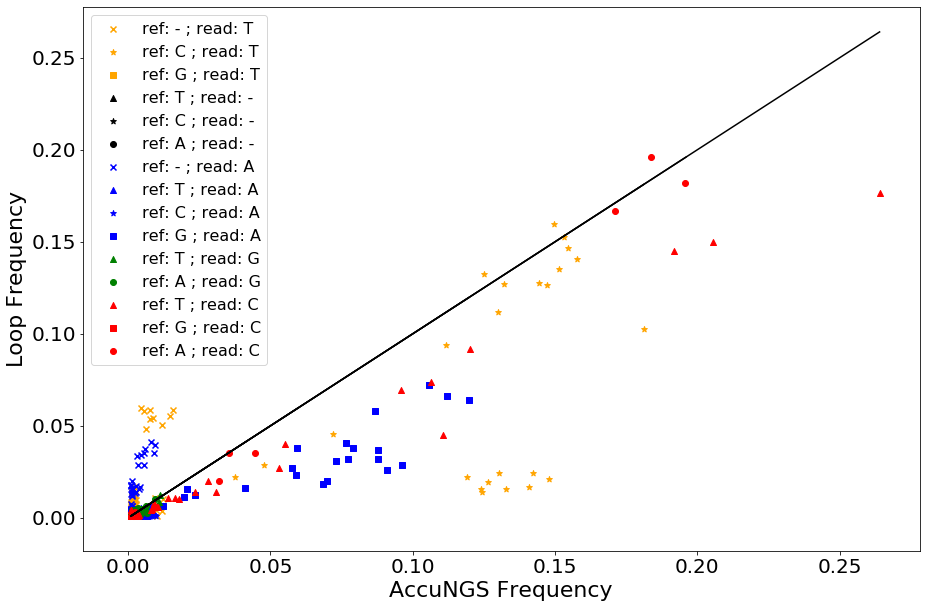

In [122]:
color_dict = {'A': 'blue', 'T': 'orange', 'G': 'green', "C": 'red', '-': 'black'}
marker_dict = {'A': 'o', 'T': '^', 'G': 's', "C": '*', '-': 'x'}
mutations_in_both.rename(columns={'frequency_i': "AccuNGS Frequency", 'frequency_l': "Loop Frequency"}, 
                         inplace=True)
plt.figure(figsize=(10*1.5, 10))
for read in mutations_in_both.read_base.unique():
    km_muts = mutations_in_both[mutations_in_both.read_base==read]
    for ref_base in mutations_in_both.ref_base.unique():
        df = km_muts[km_muts.ref_base==ref_base]
        if df.empty:
            continue
        reg_plot(df['AccuNGS Frequency'], df["Loop Frequency"], marker=marker_dict[ref_base],
                 label=f"ref: {ref_base} ; read: {read}", color=color_dict[read])
plt.legend()
plt.savefig('regplot_mutations_fancy_bases.png')

In [64]:
mutations_in_both

,ref_pos,read_base,ref_base,km,passage,base_count_i,coverage_i,AccuNGS Frequency,base_rank_i,base_count_l,coverage_l,Loop Frequency,base_rank_l,freq_ratio
0,55.001,T,-,1,3,380.0,52982.0,0.007172,0.0,11.0,1689.0,0.006513,0.0,1.101266
1,141.000,-,T,1,3,116.0,108887.0,0.001065,1.0,2.0,1700.0,0.001176,1.0,0.905526
2,224.000,T,C,1,3,17060.0,134921.0,0.126444,1.0,29.0,1472.0,0.019701,1.0,6.418141
3,261.001,T,-,1,3,168.0,135812.0,0.001237,0.0,9.0,1704.0,0.005282,0.0,0.234206
4,401.000,T,G,1,3,200.0,102277.0,0.001955,1.0,2.0,1710.0,0.001170,1.0,1.671930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,3176.000,A,G,3,10,352.0,121612.0,0.002894,1.0,24.0,5628.0,0.004264,1.0,0.678749
509,3179.000,C,T,3,10,130.0,126641.0,0.001027,1.0,7.0,5610.0,0.001248,1.0,0.822685
510,3233.000,T,C,3,10,138.0,132533.0,0.001041,1.0,6.0,5628.0,0.001066,1.0,0.976693
511,3299.000,T,C,3,10,18894.0,142951.0,0.132171,1.0,694.0,5471.0,0.126851,1.0,1.041943


In [68]:
mutations_in_both.groupby(['ref_pos', 'read_base'])['AccuNGS Frequency'].max().sort_values().tail(20).index

MultiIndex([(           3216.0, 'A'),
            (           2927.0, 'A'),
            (           1574.0, 'G'),
            (         1186.001, 'A'),
            (           3173.0, 'A'),
            (           3506.0, 'A'),
            (         1004.001, 'T'),
            (           1571.0, 'G'),
            (55.00100000000001, 'T'),
            (         1007.001, 'T'),
            (           1652.0, 'C'),
            (           1655.0, 'A'),
            (            522.0, 'A'),
            (           1649.0, 'C'),
            (           1554.0, 'A'),
            (            224.0, 'T'),
            (           3299.0, 'T'),
            (           1685.0, 'T'),
            (           1697.0, 'C'),
            (           1691.0, 'C')],
           names=['ref_pos', 'read_base'])

In [119]:
muts01 = mutations_in_both[(mutations_in_both["Loop Frequency"]<0.01) & (mutations_in_both["AccuNGS Frequency"]<0.01)]

In [120]:
top_mutations = muts01.groupby(['ref_pos','read_base'])['AccuNGS Frequency'].max().sort_values(
    ascending=False).head(20).index
top_mutations = [f'{round(pos,3)} {base}' for (pos, base) in top_mutations]
color_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45',
              '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
              '#000075', '#000000']
color_dict = {top_mutations[i]: color_list[i] for i in range(len(top_mutations))}


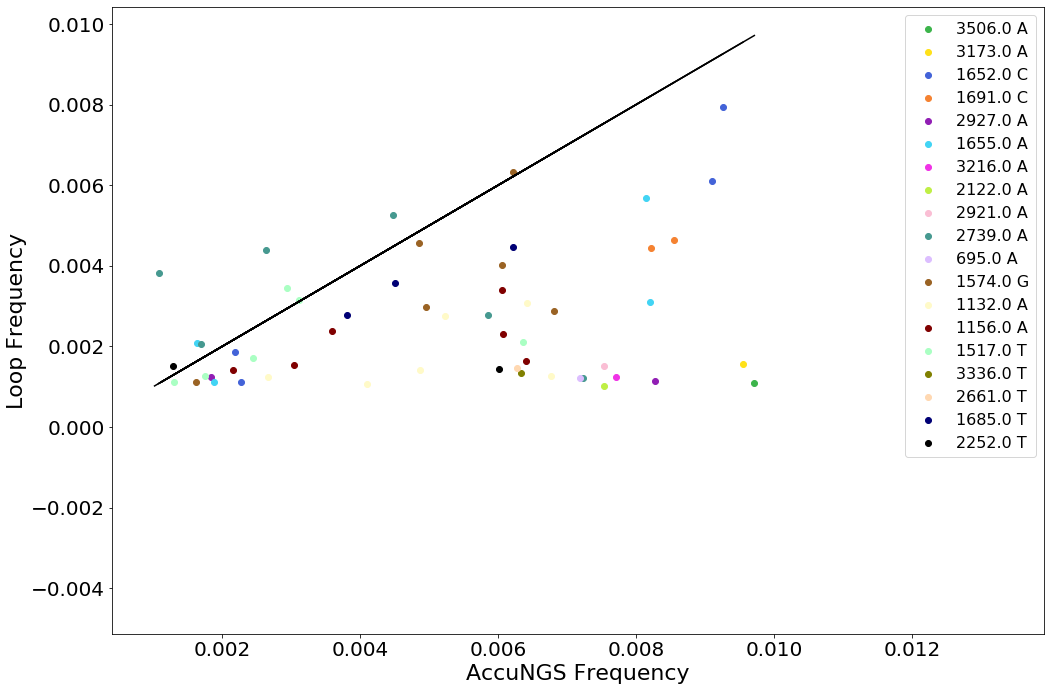

In [121]:
plt.figure(figsize=(10*1.5, 10))
for mutation in top_mutations:
    pos, base = mutation.split()
    df = muts01[(muts01.ref_pos==float(pos)) & (muts01.read_base==base)]
    if df.empty:
        continue
    reg_plot(df['AccuNGS Frequency'], df["Loop Frequency"], label=mutation, color=color_dict[mutation])
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('regplot_mutations_by_mutation.png')

In [77]:
color_dict = {'A': 'blue', 'T': 'orange', 'G': 'green', "C": 'red', '-': 'black'}
#marker_dict = {3: '+', 7: 'o', 10: '^'}
mutations_in_both.rename(columns={'frequency_i': "AccuNGS Frequency", 'frequency_l': "Loop Frequency"}, 
                         inplace=True)
plt.figure(figsize=(10*1.5, 10))
for base in mutations_in_both.ref_base.unique():
    km_muts = mutations_in_both[mutations_in_both.ref_base==base]
    
    reg_plot(km_muts['AccuNGS Frequency'], km_muts["Loop Frequency"], 
             label=f"ref_base - {base}", color=color_dict[mutation])
plt.legend()
plt.savefig('regplot_mutations_fancy.png')

NameError: name 'mutation' is not defined

<Figure size 1080x720 with 0 Axes>

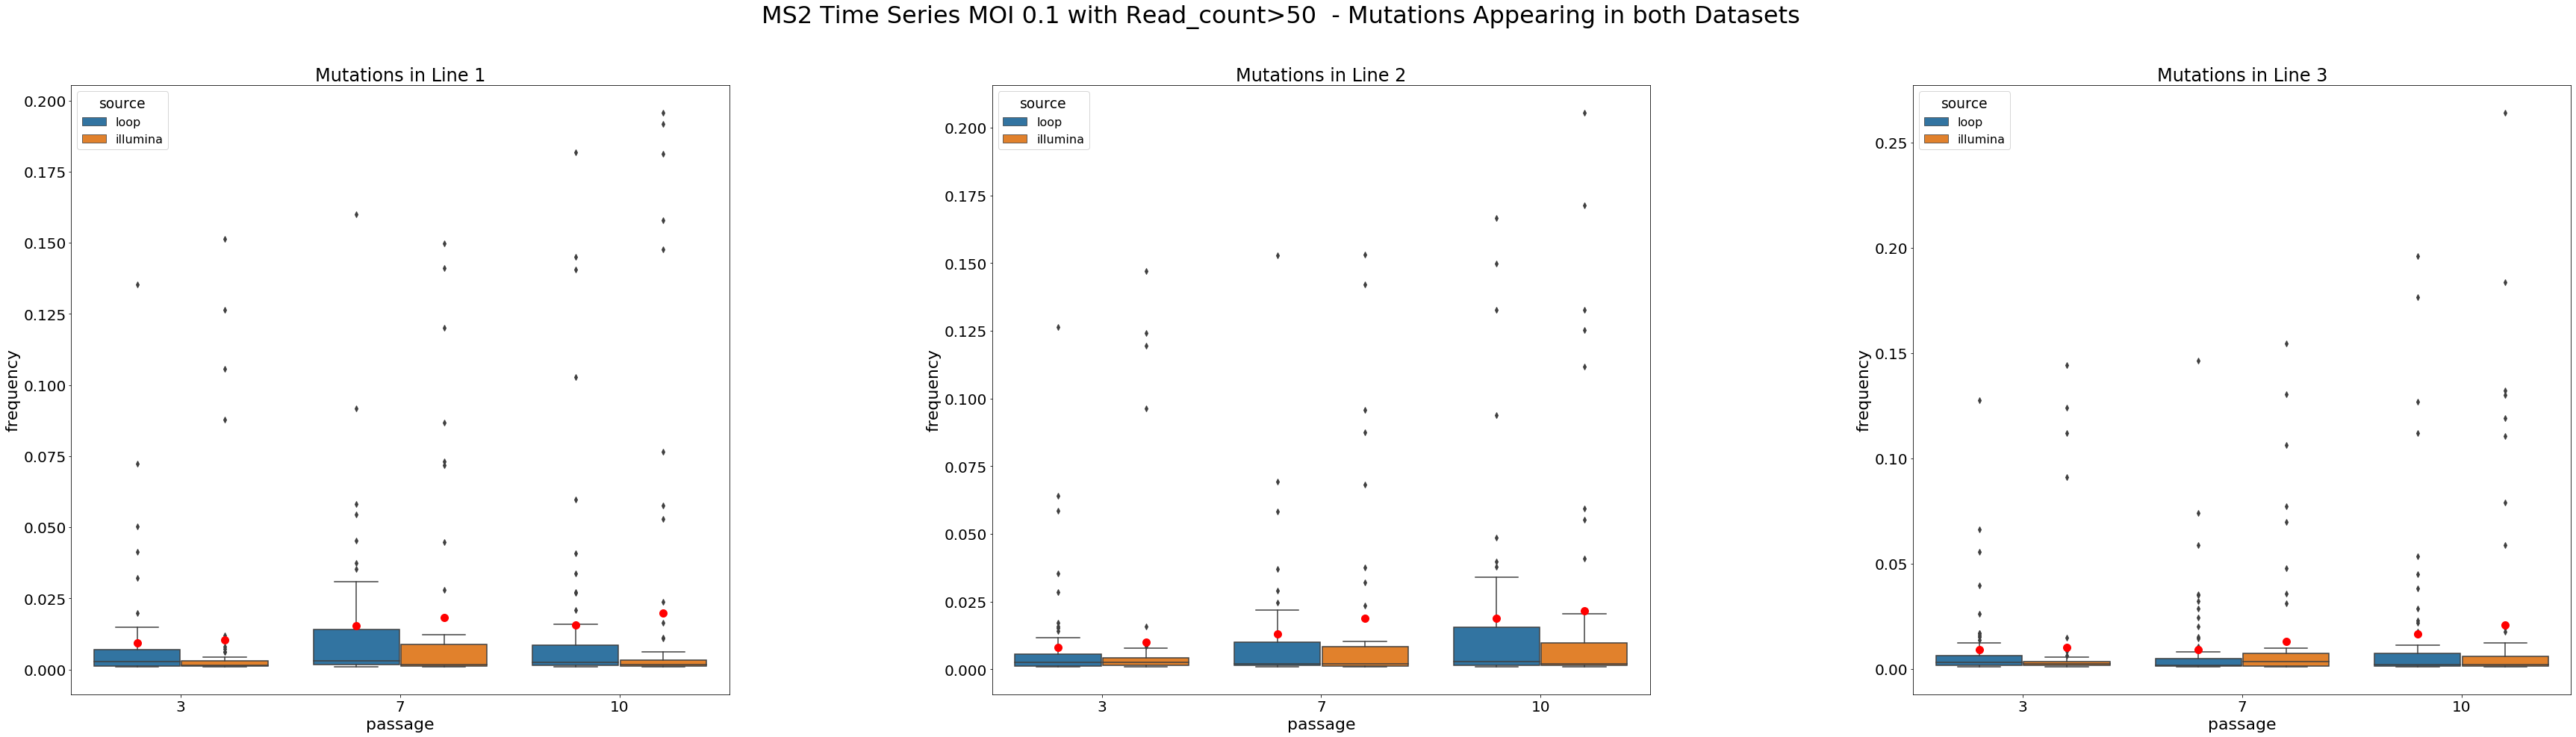

In [32]:
mutations_box_plots(joint_mutations, 
                    "MS2 Time Series MOI 0.1 with Read_count>50  - Mutations Appearing in both Datasets", 
                    log_scale=False)

# What's with the differences between loop and illumina?

In [33]:
mutations.source.value_counts()

illumina    7187
loop        3206
Name: source, dtype: int64

In [34]:
rel_pas = [3,7,10]
rel_illum = not_oxidation[(not_oxidation.passage.isin(rel_pas)) & (not_oxidation.source=='illumina')]
rel_loop = not_oxidation[(not_oxidation.passage.isin(rel_pas)) & (not_oxidation.source=='loop')]
boxplots = pd.DataFrame()
boxplots['loop'] = rel_loop.groupby(['km','passage']).ref_pos.count()
boxplots['illumina'] = rel_illum.groupby(['km','passage']).ref_base.count()
boxplots['joint'] = mutations_in_both.groupby(['km','passage']).read_base.count()

In [35]:
boxplots

loop  illumina  joint
km passage                       
1  3         365        86     60
   7         209       105     45
   10        518       165     61
2  3         243       120     69
   7         226       110     39
   10        479       149     48
3  3         217       116     64
   7         446       122     67
   10        242       166     60

Text(0.5, 1.0, 'Non Oxidation Mutations per Dataset')

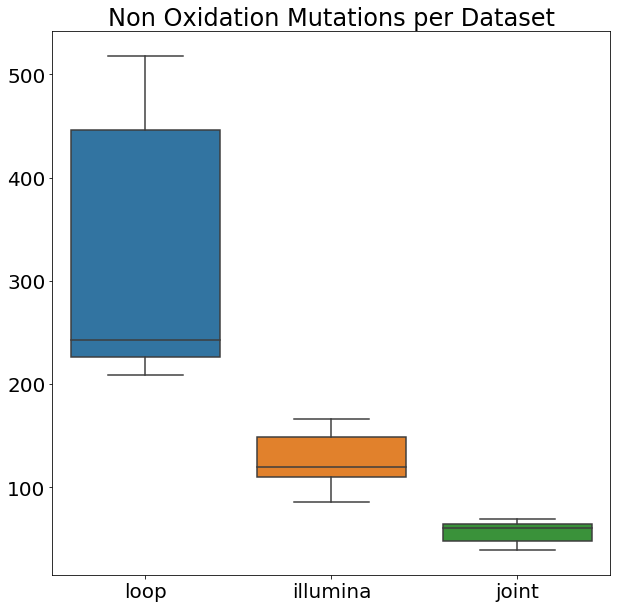

In [36]:
plt.figure(figsize=(10,10))
daplot = sns.boxplot(data=boxplots)
daplot.set_title('Non Oxidation Mutations per Dataset')

In [37]:
#daplot.figure.savefig('non oxidation mutations per dataset.png')

In [38]:
loop = mutations[(mutations.source=='loop')]
illumina = mutations[(mutations.source=='illumina')]

In [39]:
def create_pivot_table(df):
    pivot_table = df.pivot_table(index=['ref_base'], columns='read_base', aggfunc='size', fill_value=0)
    for index_val in pivot_table.index:
        if index_val not in pivot_table.columns:
            pivot_table[index_val] = [0,0,0,0,0]
    for col in pivot_table.columns:
        if col not in pivot_table.index:
            pivot_table.loc[col] = [0,0,0,0,0]
    return pivot_table.T

In [40]:
def create_heatmaps(loop_data, illumina_data, vmax):
    #TODO: align indexes and columns to same order!!!!
    fig, axes = plt.subplots(figsize=(30, 10), ncols=2, nrows=1)
    plt.suptitle("Average number of mutations per dataset")
    loop_table = create_pivot_table(loop_data)/9
    illumina_table = create_pivot_table(illumina_data)/18
    cols = illumina_table.columns
    loop_table = loop_table[cols]
    sns.heatmap(loop_table, annot=True, ax=axes[0], vmax=vmax)
    axes[0].set_title('Loop Data')
    sns.heatmap(illumina_table, annot=True, ax=axes[1], vmax=vmax)
    axes[1].set_title('Illumina Data')

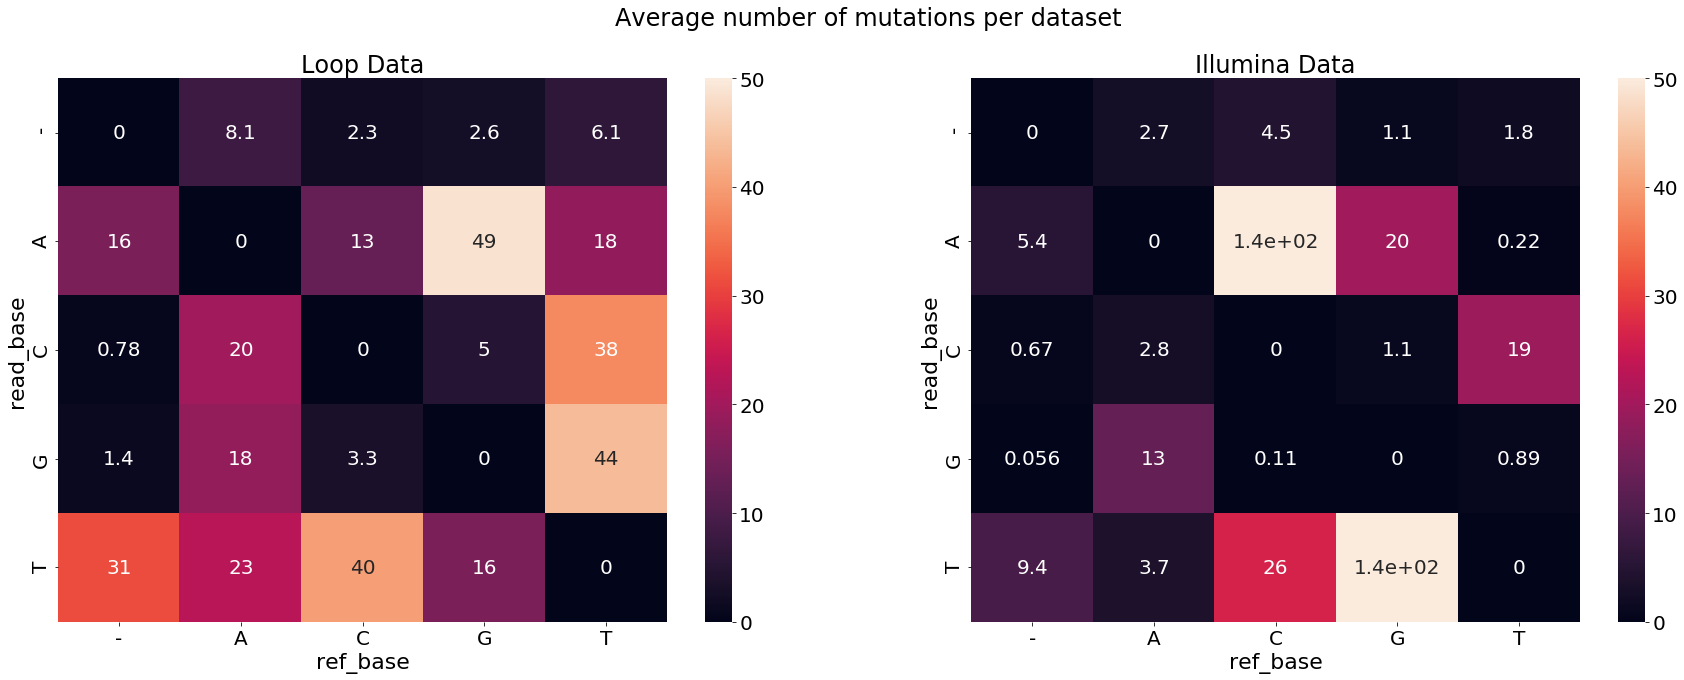

In [41]:
create_heatmaps(loop, illumina, vmax=50)

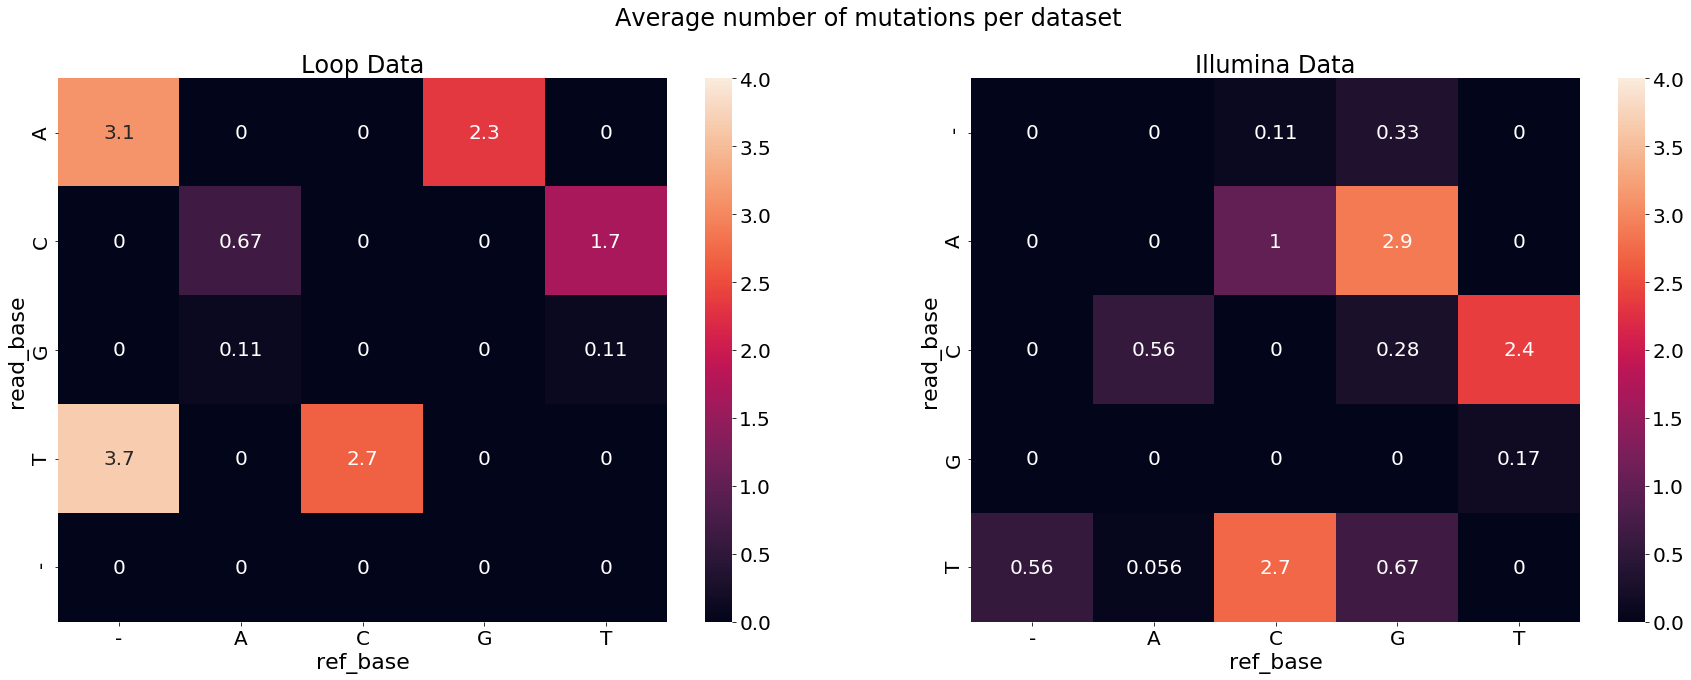

In [42]:
create_heatmaps(loop[loop.frequency>0.01], illumina[illumina.frequency>0.01], vmax=4)

In [43]:
asd = loop[loop.frequency>0.01].pivot_table(index=['ref_base'], columns='read_base', aggfunc='size', fill_value=0)
asd

read_base,A,C,G,T
ref_base,,,,
-,28,0,0,33
A,0,6,1,0
C,0,0,0,24
G,21,0,0,0
T,0,15,1,0


In [44]:
asd

read_base,A,C,G,T
ref_base,,,,
-,28,0,0,33
A,0,6,1,0
C,0,0,0,24
G,21,0,0,0
T,0,15,1,0


In [45]:
asd.columns

Index(['A', 'C', 'G', 'T'], dtype='object', name='read_base')

In [46]:
asd.columns = ['A', 'C', 'G', '-', 'T']
asd

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

In [ ]:
asd['-'] = [0,0,0,0,0]

In [ ]:
asd

In [ ]:
loop[loop.frequency>0.01]

In [ ]:
pd.crosstab(loop[loop.frequency>0.01].ref_base, loop[loop.frequency>0.01].read_base, dropna=False).stack()


In [ ]:
pd.DataFrame(loop[loop.frequency>0.01].groupby(['ref_base']).read_base.value_counts(dropna=False)).rename(
        columns={'read_base': 'count'}).reset_index()

In [ ]:
#fig.savefig('loop vs illumina heatmaps.png')

### Loop doesn't seem to have oxidation issues..

In [ ]:
not_oxidation.source.value_counts()

In [ ]:
plt.figure(figsize=(15,10))
not_oxidation.groupby('source').frequency.hist(bins=50, log=True, alpha=0.8)

## Let's take a look at the high frequency mutations:

In [ ]:
not_oxidation[not_oxidation.frequency>0.05].source.value_counts()

In [ ]:
top_mutations = not_oxidation[not_oxidation.frequency>0.05].groupby('source').ref_pos.value_counts()
top_mutations

In [ ]:
top_mutations_positions = top_mutations.index.get_level_values(1)
for pos in top_mutations_positions:
    print(pos)
    plt.figure(figsize=(15,10))
    df = mutations[mutations.ref_pos==pos].sort_values(by=['passage', 'km', 'source'])
    if pos==224:
        df = df[df.read_base=="T"]
    if pos==1554 or pos==522:
        df = df[df.read_base=="A"]
    for src in mutations.source.unique():
        tmp = df[df.source==src]
        for km in mutations.km.unique():
            tmp2 = tmp[tmp.km==km]
            plt.plot(tmp2.passage, tmp2.frequency, label=src+"_"+str(km))
    plt.legend()
    plt.show()

## And at the rest of the mutataions:

In [ ]:
mutations[mutations.frequency<0.05].source.value_counts()

In [ ]:
not_oxidation[not_oxidation.frequency<0.05].source.value_counts()

## just 513 mutations are in both data sets... Let's see if they agree:

In [ ]:
mutations_in_both.sort_values(by='freq_ratio', ascending=False)

In [ ]:
reg_plot(mutations_in_both.frequency_i, mutations_in_both.frequency_l, save_to='mutations freq regplot.png')

In [ ]:
temp = mutations_in_both[mutations_in_both.frequency_i<0.05]
reg_plot(temp.frequency_i, temp.frequency_l)

## Comparing just synonumous mutations

In [ ]:
coding_or_syn = types.set_index(['Pos','Base']).index
coding_muts = types[types.mutation_type.notna()].set_index(['Pos', 'Base']).index
non_coding_and_syns = mutations[mutations.apply(lambda row: 
                                                (row.ref_pos, row.read_base) not in coding_muts, axis=1)]
just_syn = non_coding_and_syns[non_coding_and_syns.apply(lambda row: 
                                                         (row.ref_pos, row.read_base) in coding_or_syn, axis=1)]

In [ ]:
mutations_box_plots(just_syn, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Only", 
                    log_scale=True)

In [ ]:
mutations_box_plots(just_syn[~just_syn.oxidation], 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Non Oxidation Synonymous Mutations Only", 
                    log_scale=True)

In [ ]:
syn_01 = just_syn[just_syn.frequency<0.01]
mutations_box_plots(syn_01, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Under 1% Only", 
                    log_scale=True)

In [ ]:
syn_01 = just_syn[just_syn.frequency<0.01]
mutations_box_plots(syn_01, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Under 1% Only", 
                    log_scale=False)

In [ ]:
syn_01.groupby(['km','passage','source']).frequency.median()

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
def compare_dists(df):
    loop = df[df.source=='loop']
    illumina = df[df.source=='illumina']
    if loop.empty:
        return
    return ks_2samp(loop.frequency, illumina.frequency)

In [ ]:
mutations[(mutations.km==1) & (mutations.passage==7)].groupby('source').frequency.median()

In [ ]:
mutations.groupby(['km', 'passage']).apply(lambda df: compare_dists(df))